In [118]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

galcen_frame_nosunv = coord.Galactocentric(z_sun=0*u.kpc, 
                                           galcen_v_sun=[0,0,0]*u.km/u.s)

In [119]:
H = gp.NFWPotential.from_circular_velocity(v_c=220*u.km/u.s, r_s=15*u.kpc, 
                                           units=galactic)
H = gp.Hamiltonian(H)

In [120]:
df = gd.FardalStreamDF(lead=True, trail=False)
prog_pot = gp.PlummerPotential(2e4*u.Msun, b=5*u.pc, units=galactic)
gen = gd.MockStreamGenerator(df, H, progenitor_potential=prog_pot)

w0 = gd.PhaseSpacePosition([-18., 0, 0]*u.kpc,
                           [0, 200, 0]*u.km/u.s)

stream, _ = gen.run(prog_w0=w0,
                    prog_mass=2e4*u.Msun, 
                    dt=-0.2, t1=0, t2=-6*u.Gyr, n_particles=1)

mask = ((stream.x > -19*u.kpc) & (stream.x < 15*u.kpc)
        & (stream.y > 2*u.kpc) & (stream.y < 6*u.kpc))
sub_stream = stream[mask]

In [124]:
end1 = coord.CartesianRepresentation(np.mean(stream[mask][-10:].xyz, axis=1))
end2 = coord.CartesianRepresentation(np.mean(stream[mask][:10].xyz, axis=1))
end1 = coord.SkyCoord(end1, frame=galcen_frame_nosunv).transform_to(coord.ICRS)
end2 = coord.SkyCoord(end2, frame=galcen_frame_nosunv).transform_to(coord.ICRS)

frame = gc.GreatCircleICRSFrame.from_endpoints(end1, end2)

In [125]:
stream_coords = sub_stream.to_coord_frame(frame, 
                                          galactocentric_frame=galcen_frame_nosunv)

(-2, 2)

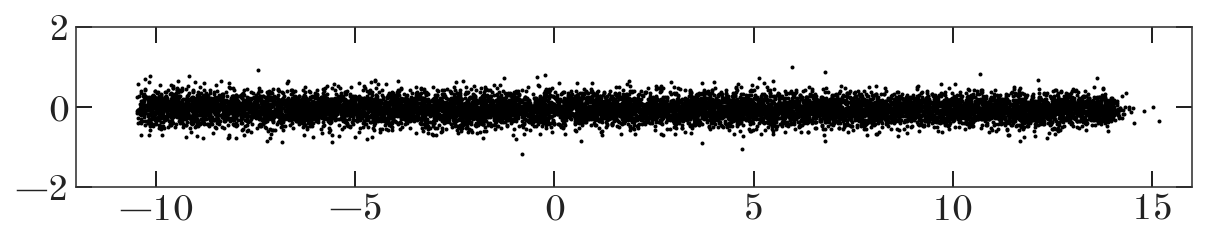

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(stream_coords.phi1.degree, stream_coords.phi2.degree, 
           lw=0, s=4)
ax.set_aspect('equal')
ax.set_xlim(-12, 16)
ax.set_ylim(-2, 2)

In [127]:
impact_site_mask = (np.abs(stream_coords.phi1.degree - 2.5) < 0.5)
impact_today_w0 = gd.PhaseSpacePosition(
    pos=sub_stream[impact_site_mask].xyz.mean(axis=1),
    vel=sub_stream[impact_site_mask].v_xyz.mean(axis=1))

impact_today_w0_coords = impact_today_w0.to_coord_frame(
    frame, galactocentric_frame=galcen_frame_nosunv)

(-2, 2)

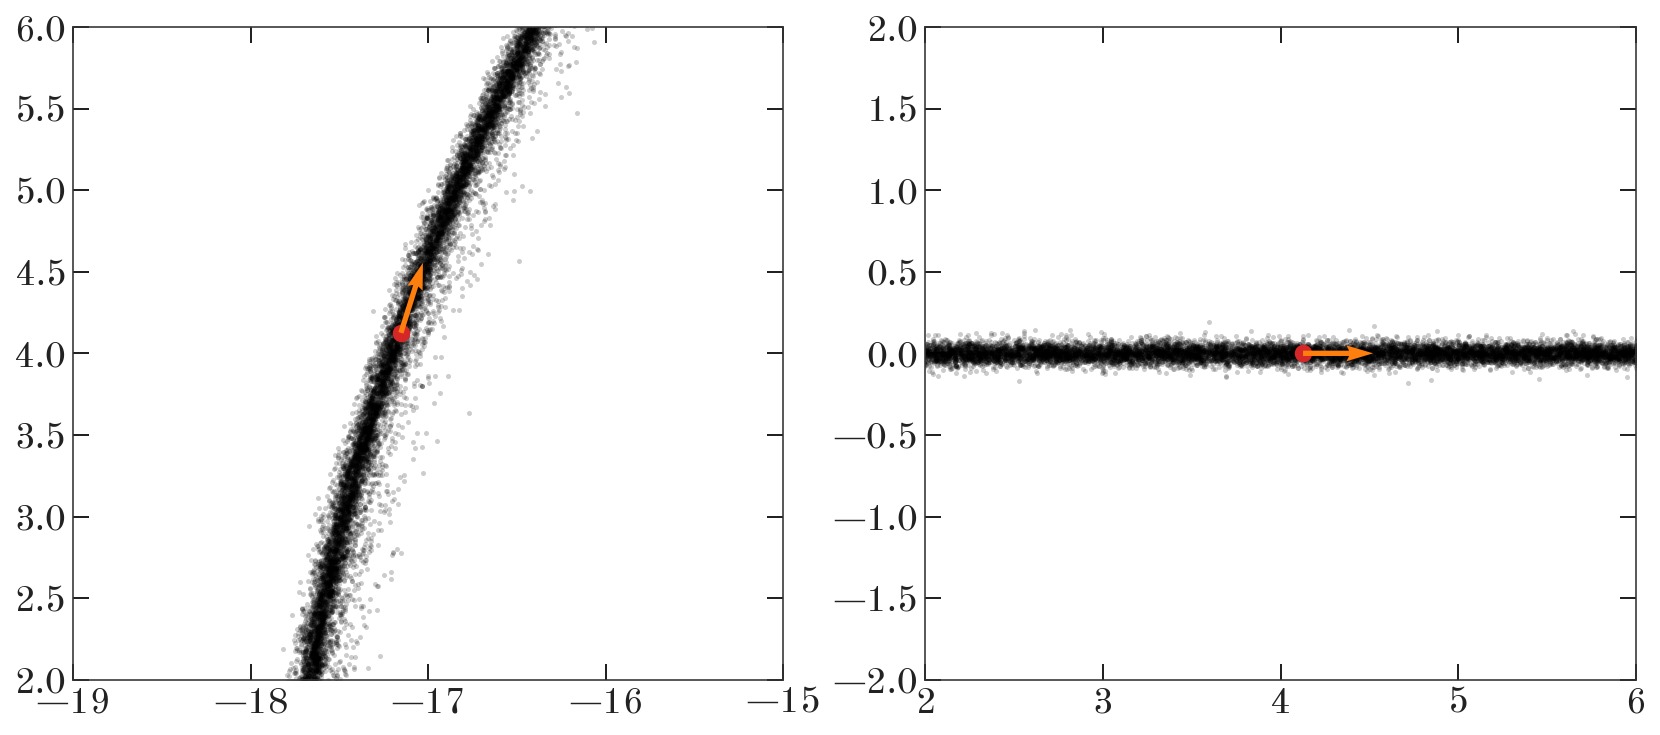

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.plot(stream.x,
        stream.y,
        marker='o', ls='none', alpha=0.2, ms=2.5)

ax.scatter(impact_today_w0.x, 
           impact_today_w0.y,
           color='tab:red', s=60, zorder=100)

ax.quiver(impact_today_w0.x.value, 
          impact_today_w0.y.value,
          impact_today_w0.v_x.value, 
          impact_today_w0.v_y.value,
          scale=2, color='tab:orange', zorder=1000)

ax.set_xlim(-19, -15)
ax.set_ylim(2, 6)

ax = axes[1]
ax.plot(stream.y,
        stream.z,
        marker='o', ls='none', alpha=0.2, ms=2.5)

ax.scatter(impact_today_w0.y, 
           impact_today_w0.z,
           color='tab:red', s=60, zorder=100)

ax.quiver(impact_today_w0.y.value, 
          impact_today_w0.z.value,
          impact_today_w0.v_y.value, 
          impact_today_w0.v_z.value,
          scale=2, color='tab:orange', zorder=1000)

ax.set_xlim(2, 6)
ax.set_ylim(-2, 2)

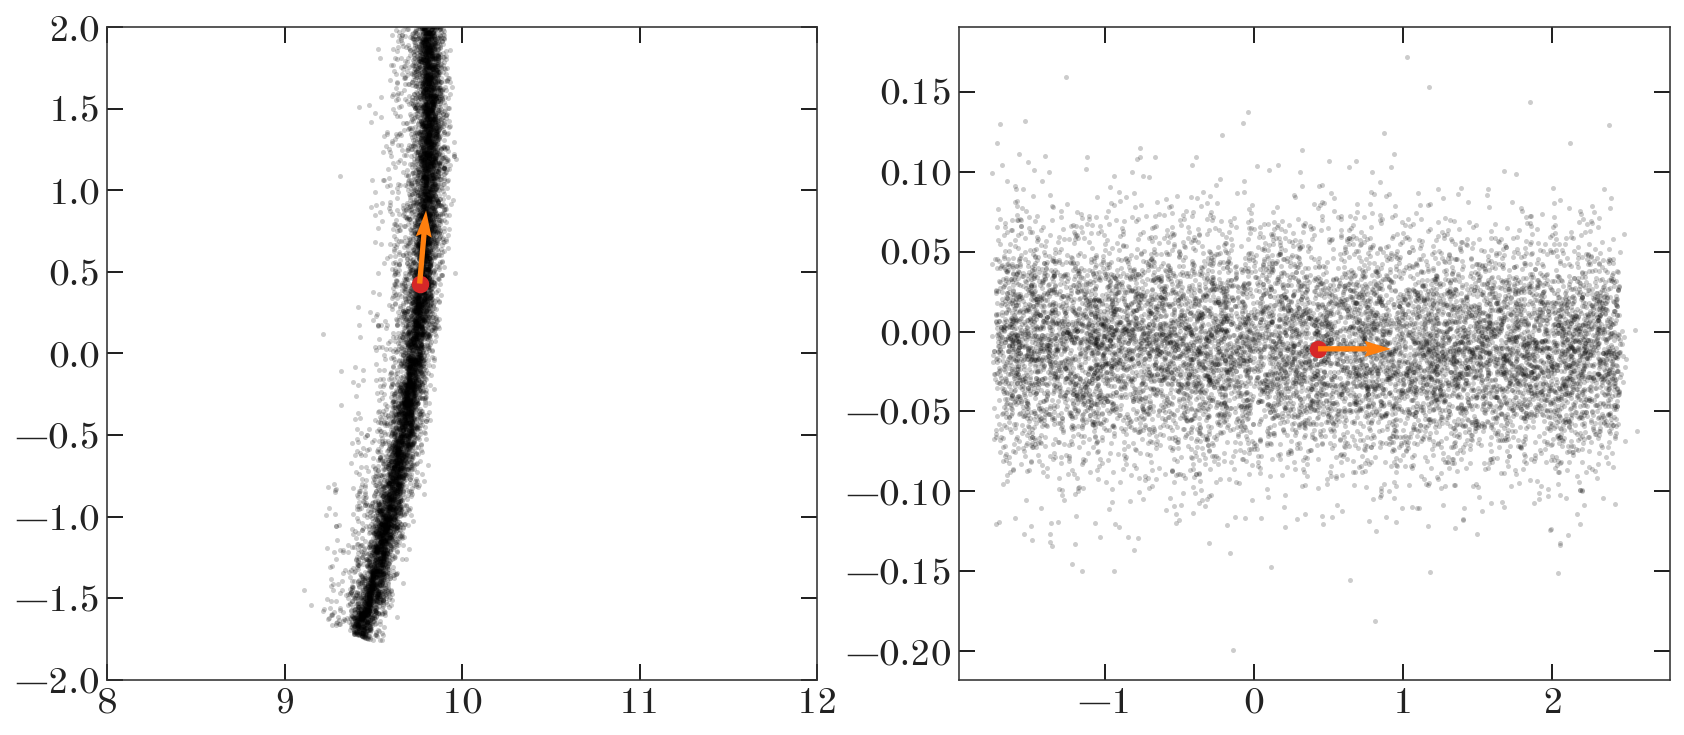

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.plot(stream_coords.data.x,
        stream_coords.data.y,
        marker='o', ls='none', alpha=0.2, ms=2.5)

ax.scatter(impact_today_w0_coords.data.x, 
           impact_today_w0_coords.data.y,
           color='tab:red', s=60, zorder=100)

ax.quiver(impact_today_w0_coords.data.x.value, 
          impact_today_w0_coords.data.y.value,
          impact_today_w0_coords.data.differentials['s'].d_x.value, 
          impact_today_w0_coords.data.differentials['s'].d_y.value,
          scale=2, color='tab:orange', zorder=1000)

ax.set_xlim(8, 12)
ax.set_ylim(-2, 2)

ax = axes[1]
ax.plot(stream_coords.data.y,
        stream_coords.data.z,
        marker='o', ls='none', alpha=0.2, ms=2.5)

ax.scatter(impact_today_w0_coords.data.y, 
           impact_today_w0_coords.data.z,
           color='tab:red', s=60, zorder=100)

ax.quiver(impact_today_w0_coords.data.y.value, 
          impact_today_w0_coords.data.z.value,
          impact_today_w0_coords.data.differentials['s'].d_y.value, 
          impact_today_w0_coords.data.differentials['s'].d_z.value,
          scale=2, color='tab:orange', zorder=1000)

Orient the stream cylinder with the z axis, but the impact site at the origin

In [132]:
# tmp_w0 = impact_past_w0
tmp_w0 = impact_today_w0
L = tmp_w0.angular_momentum()
new_z = tmp_w0.v_xyz / np.linalg.norm(tmp_w0.v_xyz, axis=0)
new_x = L / np.linalg.norm(L, axis=0)
new_y = -np.cross(new_x, new_z)

origin = tmp_w0.data.without_differentials()
R = np.stack((new_x, new_y, new_z))

In [133]:
cyl_pts = coord.CylindricalRepresentation(
    rho=100*u.pc,
    phi=np.arange(0, 2*np.pi, 2*np.pi/128)*u.radian,
    z=0*u.pc)

cyl_pts = cyl_pts.to_cartesian()

In [147]:
derp = cyl_pts.transform(R.T) + origin
derp_coords = coord.SkyCoord(derp, frame=galcen_frame_nosunv).transform_to(frame)

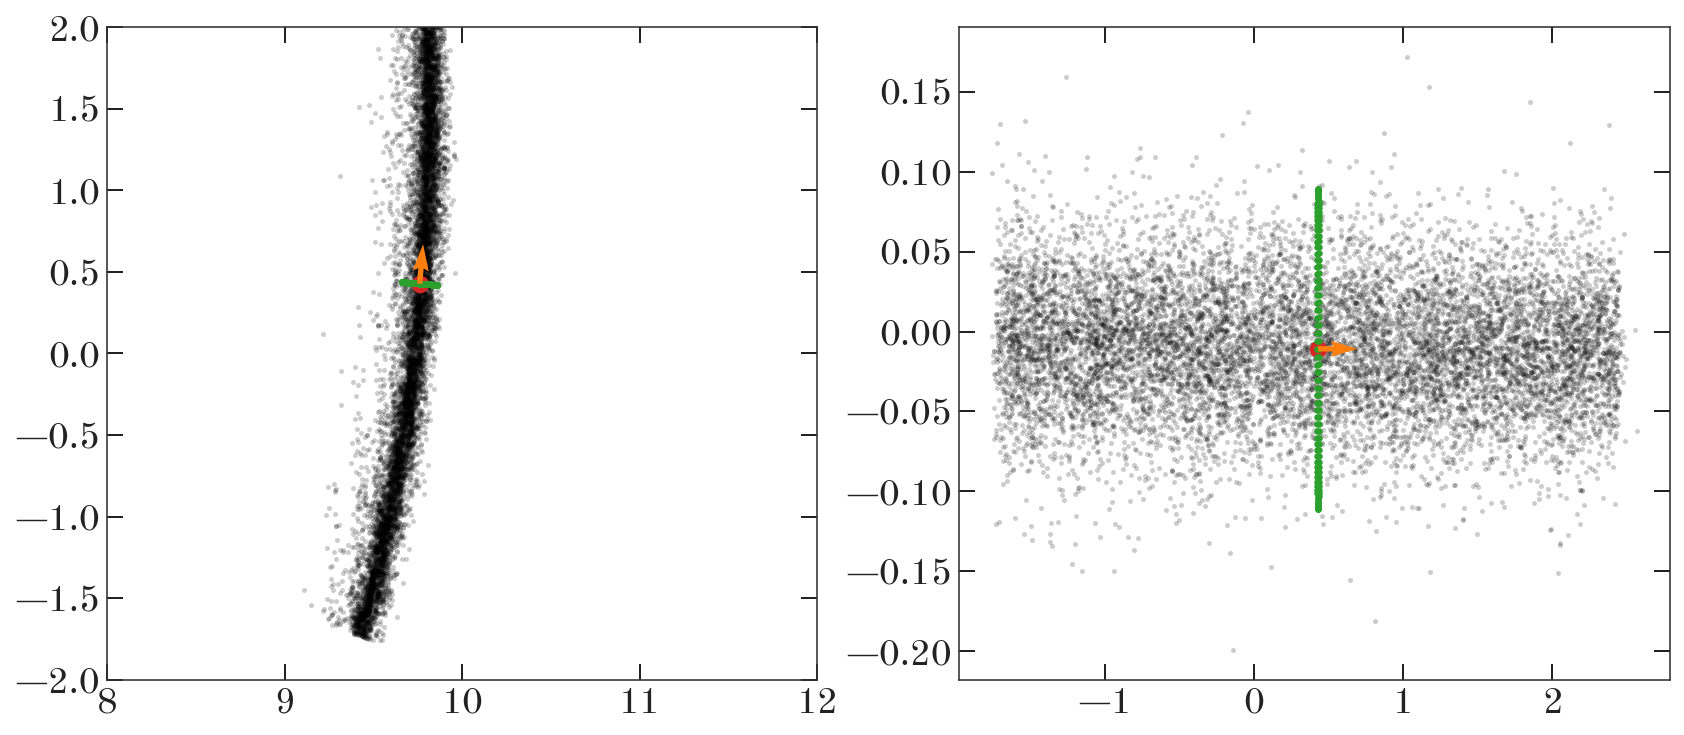

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.plot(stream_coords.data.x,
        stream_coords.data.y,
        marker='o', ls='none', alpha=0.2, ms=2.5)

ax.scatter(impact_today_w0_coords.data.x, 
           impact_today_w0_coords.data.y,
           color='tab:red', s=60, zorder=100)

ax.quiver(impact_today_w0_coords.data.x.value, 
          impact_today_w0_coords.data.y.value,
          impact_today_w0_coords.data.differentials['s'].d_x.value, 
          impact_today_w0_coords.data.differentials['s'].d_y.value,
          color='tab:orange', zorder=1000)

ax.scatter(derp_coords.data.to_cartesian().x.to(u.kpc), 
           derp_coords.data.to_cartesian().y.to(u.kpc),
           color='tab:green', s=5, zorder=200)

ax.set_xlim(8, 12)
ax.set_ylim(-2, 2)

ax = axes[1]
ax.plot(stream_coords.data.y,
        stream_coords.data.z,
        marker='o', ls='none', alpha=0.2, ms=2.5)

ax.scatter(impact_today_w0_coords.data.y, 
           impact_today_w0_coords.data.z,
           color='tab:red', s=60, zorder=100)

ax.quiver(impact_today_w0_coords.data.y.value, 
          impact_today_w0_coords.data.z.value,
          impact_today_w0_coords.data.differentials['s'].d_y.value, 
          impact_today_w0_coords.data.differentials['s'].d_z.value,
          color='tab:orange', zorder=1000)

ax.scatter(derp_coords.data.to_cartesian().y.to(u.kpc), 
           derp_coords.data.to_cartesian().z.to(u.kpc),
           color='tab:green', s=5, zorder=200)